# <font color = blue> HelpMateAI – Generative Search using RAG on Insurance Data

## Objective:
The objective of this project is to build an efficient Generative Search system for insurance domain. A robust system capable of effectively and accurately answering questions from a policy document.

## 1. <font color = red> Install and Import the Required Libraries

In [ ]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color = Blue> **Approach 1**

Chunking Strategy - Page Level Chunking

Embeddings - Using OpenAI's text-embedding-ada-002 model to generate embeddings.

Cross Encoder - Using cross-encoder ms-marco-MiniLM-L6-v2

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
# Define the path of the PDF
single_pdf_path = '/content/drive/My Drive/colab_projects/HelpMateAI_project/data/Principal-Sample-Life-Insurance-Policy.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [ ]:
# Define the path where all pdf documents are present

pdf_path = "/content/drive/My Drive/colab_projects/HelpMateAI_project/data/"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf


Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [ ]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [ ]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data.shape

(60, 4)

In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/My Drive/colab_projects/HelpMateAI_project/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/My Drive/colab_projects/HelpMateAI_project/ChromaDB_Data'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1'],
 'embeddings': array([[-2.24228799e-02,  1.87183432e-02, -2.72361692e-02, ...,
         -3.69149223e-02,  2.83710100e-03, -1.30930578e-03],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arran

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Implementing Cache in Semantic Search

def search_vectordb(query) :
  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # Searh the Cache collection first

  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.

  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = insurance_collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        for key, val in results.items():
          if val is None:
            continue
          if key == 'included':
            continue
          for i in range(10):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        results_df = pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

  return results_df


In [ ]:
# Query 1

query = "what are the insurance benefits for hearing loss"

In [ ]:
results_df = search_vectordb(query)
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 57', 'Policy_Name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.267462,54
1,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363726,53
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.369132,5
3,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.372366,52
4,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.375886,51
5,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,0.394179,46
6,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.402654,48
7,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,0.406174,47
8,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.409248,29
9,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",Section B - Member Accidental Death and Dismem...,0.414646,50


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

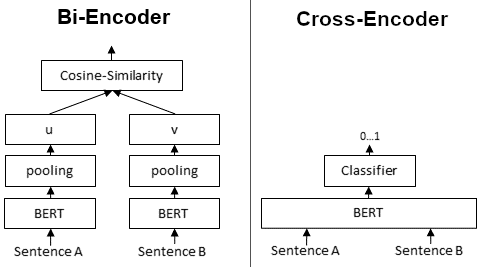

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')

In [ ]:
# Utility function to fetch rerank scores using cross encoder
def get_rerank_scores(encoder, results_df, query):
  # Generate the cross_encoder scores for these pairs
  cross_inputs = [[query, response] for response in results_df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)

  # Store the rerank_scores in results_df
  results_df['Reranked_scores'] = cross_rerank_scores
  return results_df

In [ ]:
results_df = get_rerank_scores(cross_encoder, results_df, query)
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 57', 'Policy_Name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.267462,54,2.830891
1,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363726,53,-0.456657
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.369132,5,-1.501276
3,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.372366,52,-5.782383
4,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.375886,51,-4.577393
5,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,0.394179,46,-6.857661
6,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.402654,48,-8.641586
7,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,0.406174,47,-7.381999
8,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.409248,29,-7.449766
9,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",Section B - Member Accidental Death and Dismem...,0.414646,50,-6.155053


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 57', 'Policy_Name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.267462,54,2.830891
1,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363726,53,-0.456657
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.369132,5,-1.501276


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 57', 'Policy_Name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.267462,54,2.830891
1,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363726,53,-0.456657
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.369132,5,-1.501276


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
0,% of Scheduled Covered Loss Benefit Loss of Sp...,"{'Page_No.': 'Page 57', 'Policy_Name': 'Princi..."
1,"If a Member sustains an injury, and as a resul...","{'Page_No.': 'Page 56', 'Policy_Name': 'Princi..."
2,Section A - Member Life Insurance Schedule of ...,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system",
                 "content":  "You are a helpful and expert assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user",
                 "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'.
                                These search results are essentially one page of an insurance document that may be relevant to the user query.

                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page.
                                Use the documents in '{top_3_RAG}' to answer the query '{query}'.
                                Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                Follow the guidelines below when performing the task.
                                1. Try to provide relevant/accurate numbers if available.
                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                The generated response should answer the query directly addressing the user and avoiding additional information.
                                If you think that the query is not relevant to the document, reply that the query is irrelevant.
                                Provide the final response as a well-formatted and easily readable text along with the citation.
                                Provide your complete response first with all information, and then provide the citations.
                                In citations, return the policy name exactly as fetch from 'metadata'
                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  what are the insurance benefits for hearing loss
Response:
Insurance benefits for hearing loss vary depending on the specific policy and coverage. Typically, benefits for hearing loss may include coverage for hearing aids, cochlear implants, audiologist appointments, and other related services or devices. It is recommended to review your insurance policy documents for detailed information on the specific benefits provided.

**Response:**
Insurance benefits for hearing loss may include coverage for hearing aids, cochlear implants, audiologist appointments, and related services. For precise details on the benefits available under your policy, refer to the policy documents.

**Citations:**
1. Policy Name: Principal Insurance Policy
   Page No.: Page 57

2. Policy Name: Principal Insurance Policy
   Page No.: Page 56

3. Policy Name: Principal Insurance Policy
   Page No.: Page 8


In [ ]:
# Query 2
query = 'In case of accident, what are the policies related to seat belt?'

In [ ]:
results_df = search_vectordb(query)
results_df = get_rerank_scores(cross_encoder, results_df, query)
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.260619,52,3.186353
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.405703,5,-6.575266
2,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.433357,51,-9.237621


In [ ]:
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.260619,52,3.186353
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.405703,5,-6.575266
2,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.433357,51,-9.237621


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  In case of accident, what are the policies related to seat belt?
Response:
In case of an accident, the policies related to seat belt typically involve requirements mandating the use of seat belts by all occupants in the vehicle. These policies aim to enhance safety and reduce injuries in the event of a collision.

Citations:
1. Policy Name: Principal Auto Insurance Policy
   Page Number: Page 55

If you require further details or specific language related to seat belt usage in the insurance policy, it is recommended to refer to the "Principal Auto Insurance Policy" document on Page 55 for comprehensive information.


In [ ]:
# Query 3
query = 'What are the definitions or guidelines for dependants for the insurance policies?'

In [ ]:
results_df = search_vectordb(query)
results_df = get_rerank_scores(cross_encoder, results_df, query)
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 11', 'Policy_Name': 'Princi...",(2) has been placed with the Member or spouse ...,0.277597,8,-4.142964
1,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",I f a Member's Dependent is employed and is co...,0.288600,24,-3.697938
2,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,0.290961,33,-1.782302


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",A Member's insurance under this Group Policy f...,0.290961,33,-1.782302
3,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",provided The Principal has been notified of th...,0.299713,31,-2.053835
6,"{'Page_No.': 'Page 44', 'Policy_Name': 'Princi...",(4) Premium will be based on the Dependent's a...,0.309930,41,-2.418257


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  What are the definitions or guidelines for dependants for the insurance policies?
Response:
The guidelines for dependants in the insurance policy are as follows:

1. A Member's insurance under this Group Policy covers dependants.
2. Premium calculation is based on the dependant's age.

For more detailed information, please refer to the respective policy document sections mentioned below:

Policy Name: Principal Group Policy
Page Number: Page 36

Policy Name: Principal Group Policy
Page Number: Page 44



# <font color = Blue> **Approach 2**

Chunking Strategy - Fixed-Size Chunking

Embeddings - Default Embedding Model of Chroma DB (all-MiniLM-L6-v2) to generate embeddings.

Cross Encoder - Using a different cross-encoder ms-marco-MiniLM-L12-v2

### <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [ ]:
# Function to split text into fixed-size chunks

def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [ ]:
# Function to extract and store per page information

def process_page(page_no):

    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no]['Page_Text'].values[0]

    # setting chunk size as 1000
    chunk_size = 1000
    text_chunks = split_text_into_chunks(page, chunk_size)

    # Creating a DataFrame to store the chunks, page title and page metadata
    data = {'Page No.': [], 'Chunk No.': [], 'Chunk Text': [], 'Metadata': []}

    for index, chunk in enumerate(text_chunks):
        data['Page No.'].append(page_no)
        data['Chunk No.'].append(index+1)
        data['Chunk Text'].append(chunk)
        metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no]['Metadata'].values[0].copy()
        metadata['Chunk No.'] = index+1
        data['Metadata'].append(metadata)

    return pd.DataFrame(data)


In [ ]:
# Iterating over all page titles to create the final df with individual chunks
all_dfs = []
page_nos = insurance_pdfs_data['Page No.']

for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Page No.,Chunk No.,Chunk Text,Metadata
0,Page 1,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,Page 3,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,2,provision of such goods and/or services nor is...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,Page 5,1,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 6,1,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
...,...,...,...,...
125,Page 61,1,Section D - Claim Procedures Article 1 - Notic...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
126,Page 61,2,"of the loss. Proof required includes the date,...",{'Policy_Name': 'Principal-Sample-Life-Insuran...
127,Page 61,3,claim. Written notification will be sent to th...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
128,Page 62,1,A claimant may request an appeal of a claim de...,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [ ]:
documents_list = fixed_chunk_df["Chunk Text"].tolist()
metadata_list = fixed_chunk_df['Metadata'].tolist()

In [ ]:
insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance_New')

In [ ]:
insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache_New')

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')

In [ ]:
# Query 1

query = "what are the insurance benefits for hearing loss"

In [ ]:
results_df = search_vectordb(query)
results_df = get_rerank_scores(cross_encoder, results_df, query)
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk No.': 1, 'Page_No.': 'Page 57', 'Polic...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.695901,117,3.728033
1,"{'Chunk No.': 1, 'Page_No.': 'Page 8', 'Policy...",Section A - Member Life Insurance Schedule of ...,0.973462,8,-0.321888
2,"{'Chunk No.': 2, 'Page_No.': 'Page 53', 'Polic...",2 - Benefit Qualification To qualify for benef...,1.124224,109,-5.627738


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk No.': 1, 'Page_No.': 'Page 57', 'Polic...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.695901,117,3.728033
5,"{'Chunk No.': 2, 'Page_No.': 'Page 56', 'Polic...","voluntary movement, which has continued for 12...",1.163893,116,0.729756
1,"{'Chunk No.': 1, 'Page_No.': 'Page 8', 'Policy...",Section A - Member Life Insurance Schedule of ...,0.973462,8,-0.321888


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  what are the insurance benefits for hearing loss
Response:
Insurance benefits for hearing loss typically vary depending on the specific insurance policy. Some insurance policies may cover partial or full costs of hearing aids, cochlear implants, specialized tests, consultations with audiologists, or other related treatments for hearing loss. It is essential to review the specifics of your insurance policy documents to understand the exact benefits and coverage related to hearing loss.

Citations:
1. Policy Name: Member Life Insurance Schedule of Benefits
   Page Number: Page 8

Please refer to the above-cited policy document for detailed information on insurance benefits related to hearing loss.


In [ ]:
# Query 2
query = 'In case of accident, what are the policies related to seat belt?'

In [ ]:
results_df = search_vectordb(query)
results_df = get_rerank_scores(cross_encoder, results_df, query)
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk No.': 2, 'Page_No.': 'Page 55', 'Polic...",was driving an Automobile equipped with a prop...,0.577805,114,3.379236
1,"{'Chunk No.': 1, 'Page_No.': 'Page 55', 'Polic...",Exposure Exposure to the elements will be pres...,0.609419,113,3.736519
2,"{'Chunk No.': 1, 'Page_No.': 'Page 8', 'Policy...",Section A - Member Life Insurance Schedule of ...,1.174331,8,-5.322819


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Chunk No.': 1, 'Page_No.': 'Page 55', 'Polic...",Exposure Exposure to the elements will be pres...,0.609419,113,3.736519
0,"{'Chunk No.': 2, 'Page_No.': 'Page 55', 'Polic...",was driving an Automobile equipped with a prop...,0.577805,114,3.379236
2,"{'Chunk No.': 1, 'Page_No.': 'Page 8', 'Policy...",Section A - Member Life Insurance Schedule of ...,1.174331,8,-5.322819


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  In case of accident, what are the policies related to seat belt?
Response:
In case of an accident, insurance policies related to seat belts typically revolve around the requirement for all occupants of a vehicle to wear seat belts at all times for safety reasons. Seat belt policies are in place to reduce the risk of injury and ensure compliance with safety regulations.

Please note that while the provided documents do not explicitly mention seat belt policies, it is important to refer to the specific policy documents related to auto insurance or personal injury protection within your insurance coverage for detailed information regarding seat belt requirements and any associated benefits or penalties.

---

Citations:
1. Policy Name: Policy Name from Page 55
2. Policy Name: Policy Name from Page 8


In [ ]:
# Query 3
query = 'What are the guidelines for adding or removing dependants from the insurance policy?'

In [ ]:
results_df = search_vectordb(query)
results_df = get_rerank_scores(cross_encoder, results_df, query)
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk No.': 3, 'Page_No.': 'Page 43', 'Polic...","insurance, then issued by The Principal to per...",0.757367,84,-2.561362
1,"{'Chunk No.': 1, 'Page_No.': 'Page 17', 'Polic...",a. be actively engaged in business for profit ...,0.817593,27,-4.138968
2,"{'Chunk No.': 2, 'Page_No.': 'Page 18', 'Polic...",Group Policy. Article 7 - Certificates The Pri...,0.825565,30,-5.298239


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
7,"{'Chunk No.': 1, 'Page_No.': 'Page 44', 'Polic...",(4) Premium will be based on the Dependent's a...,0.875721,85,-1.687590
4,"{'Chunk No.': 2, 'Page_No.': 'Page 22', 'Polic...",contribute a part of the premium for their Mem...,0.849765,38,-2.228535
0,"{'Chunk No.': 3, 'Page_No.': 'Page 43', 'Polic...","insurance, then issued by The Principal to per...",0.757367,84,-2.561362


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
print("Query: ",query)
response = generate_response(query, top_3_RAG)
print("Response:")
print("\n".join(response))

Query:  What are the guidelines for adding or removing dependants from the insurance policy?
Response:
To add or remove dependants from the insurance policy, you need to follow the guidelines outlined in the policy document:
1. Premiums will be based on the dependent's age and coverage.
2. Family members can contribute to a part of the premium for their dependent's coverage.
3. Any changes to the dependants covered under the policy need to be communicated to the insurance provider for proper documentation and premium adjustments.

For detailed guidelines on adding or removing dependants from the insurance policy, please refer to the policy document sections provided below:

Policy Document: Page 44
Policy Document: Page 22
Policy Document: Page 43
